<a href="https://colab.research.google.com/github/Az-Data/Portfolio/blob/master/Most%20Common%20Languages%20of%20the%20World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Most Common Languages of the World

We will find the most popular languages in the world and display them in an interactive geographical plot.

In [1]:
import requests
import os
import runpy

url = "https://raw.githubusercontent.com/Az-Data/Portfolio/master/utilities.py"
file_name = "utilities.py"  # Name to save the file locally

# Download the utilites setup file
response = requests.get(url)
if response.status_code == 200:
    with open(file_name, "wb") as f:
        f.write(response.content)
    print(f"{file_name} downloaded successfully.")
else:
    print("Failed to download the file.")

utilities.py downloaded successfully.


In [2]:
# Using %run magic command
%%capture
%run utilities.py

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import geopandas as gp

plt.rcParams['figure.figsize'] = 15, 15

# widget packages
import ipywidgets as widgets

Data Source: https://www.kaggle.com/datasets/zinovadr/language-list-by-country-and-place

I heavily modified the dataset with the languages from wikipedia, as well as adding a few missing countries. I also renamed a few of the countries to the more common name.  

In [4]:
lang_df = pd.read_excel('Data/Language List by Country and Place (amended).xlsx')

# Data wrangling
lang_df.columns = lang_df.columns.str.strip()
lang_df['Language'] = lang_df['Language'].str.split(', ')
lang_df.dropna(subset='Language', inplace=True)
result = lang_df.explode('Language')
result['Language'] = result['Language'].str.strip()
result['Country'] = result['Country'].str.strip()

# The Most Widespread Languages

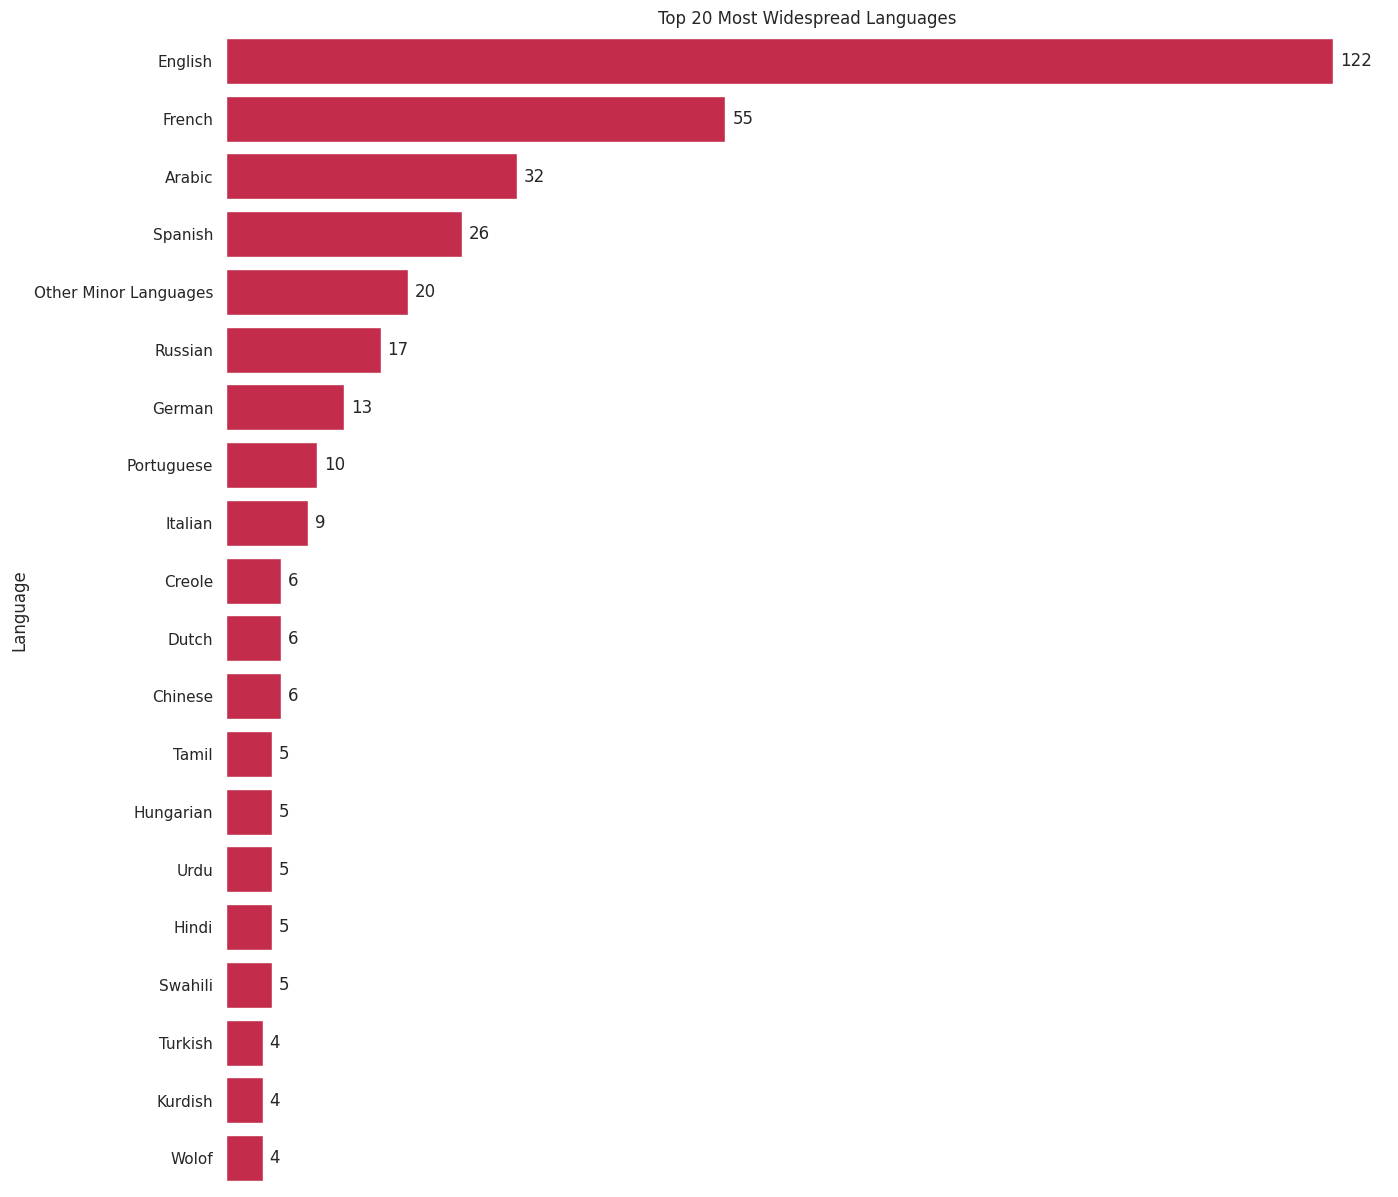

In [5]:
# grouping the df to get the count of the countries for each language
grouped = result.groupby('Language',as_index=False).count()
grouped.sort_values('Country', ascending=False, inplace=True)

# Create a horizontal bar chart
sns.set(style="whitegrid")
fig, ax = plt.subplots()
sns.barplot(
    grouped[:20],
    x='Country',
    y='Language',
    color='crimson')

# Remove borders and x-axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)

# Add value labels at the end of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', label_type='edge', padding=5)

plt.title('Top 20 Most Widespread Languages')
plt.show()

# Mapping

In [6]:
raw_world = gp.read_file('Data/Countries/ne_10m_admin_0_countries.shp')
world = raw_world[['NAME', 'POP_EST', 'POP_YEAR', 'POP_RANK', 'geometry']]
# world.plot(cmap='jet', figsize=(15,15))
# plt.axis('off')
# plt.show()

In [7]:
# world.head()

In [8]:
# replace values that are abbreviated so they match the excel sheet
replacement_dict = {
    'Antigua and Barb.':'Antigua and Barbuda',
    'Bosnia and Herz.':'Bosnia and Herzegovina',
    'Brunei':'Brunei Darussalam',
    'Cabo Verde':'Cape Verde',
    'Central African Rep.':'Central African Republic',
    'Czechia':'Czech Republic',
    "Côte d'Ivoire":'Ivory Coast',
    'Akrotiri':'Akrotiri and Dhekelia',
    'Dominican Rep.':'Dominican Republic',
    'Eq. Guinea':'Equatorial Guinea',
    'Br. Indian Ocean Ter.':'British Indian Ocean Territory',
    'Macao':'Macau',
    'Marshall Is.':'Marshall Islands',
    'N. Cyprus':'North Cyprus',
    'N. Mariana Is.':'Northern Mariana Islands',
    'Netherlands':'The Netherlands',
    'Philippines':'The Philippines',
    'Pitcairn Is.':'Pitcairn Island',
    'S. Geo. and the Is.':'South Georgia and the South Sandwich Islands',
    'S. Sudan':'South Sudan',
    'Saint Lucia':'St. Lucia',
    'Solomon Is.':'Solomon Islands',
    'St-Barthélemy':'St. Barthélemy',
    'St-Martin':'St. Martin',
    'St. Vin. and Gren.':'St. Vincent and the Grenadines',
    'Timor-Leste':'East Timor',
    'Turks and Caicos Is.':'Turks and Caicos Island',
    'U.S. Virgin Is.':'U.S. Virgin Islands',
    'W. Sahara':'Western Sahara',
    'Wallis and Futuna Is.':'Wallis and Futuna Island',
    'eSwatini':'Eswatini',
    "Faeroe Is.":'Faroe Islands',
    'Cayman Is.':'Cayman Island',
    'British Virgin Is.':'British Virgin Island',
    'Falkland Is.':'Falkland Island',
    'Fr. Polynesia':'French Polynesia'
}


In [9]:
# Use .loc to replace values in the column
for old_value, new_value in replacement_dict.items():
    world.loc[world['NAME'] == old_value, 'NAME'] = new_value

# merging the 20 df from above with the geopandas df
merged = pd.merge(world, result, how='left', left_on='NAME', right_on='Country')
merged.dropna(inplace=True)

# Limiting the dataframe to the top 20, and creating a cross tabulation
top_20 = pd.crosstab(merged['NAME'], merged['Language'])[grouped.nlargest(20, 'Country')['Language']].reset_index()

# creating the final geopandas df for the top 20 languages
finaldf = pd.merge(world, top_20, on='NAME', how='left')

# finaldf.head()

In [14]:
#creating the interactive geopandas plot

select_menu = widgets.Select(
    options=list(grouped[:20]['Language']),
    value='English',
    description='Language:',
    disabled=False,
    rows=7
    )

def popularity_plot(language):
    fig, ax = plt.subplots(1, 1)

    # Create a color mapping: red for value=1, grey for others
    finaldf['color'] = finaldf[language].map({0.0:'lightgrey', 1.0:'crimson'}).fillna('lightgrey')

    finaldf.plot(
        color=finaldf['color'],
        ax=ax,
        # vmax=1,
        # vmin=0,
        linewidth=0.1,
        edgecolor='grey',
        missing_kwds={'color': 'lightgrey'}
        )
    plt.title(language)
    plt.axis('off')
    plt.show()


display(widgets.interact(popularity_plot, language=select_menu))


interactive(children=(Select(description='Language:', options=('English', 'French', 'Arabic', 'Spanish', 'Othe…